# Task 3

The following versions of libraries have been used in this question. Please make sure that you use the same versions as well:

- python: 3.7.*
- keras: 2.3.1 
- tensorflow: 2.4.*

The first part of this task includes a tutorial on how to use Keras for a simple classification of dogs and cats. We use [the official keras documentation](https://keras.io/examples/vision/image_classification_from_scratch/). The next part is extending this knowledge to a novel multi-class classification task.

# Tutorial (Not Graded)

## Imports
The first step is to import some of the packages that we need.

In [ ]:
# TensorFlow
import tensorflow as tf
# Keras
from tensorflow import keras
# Easy layer-by-layer way to create neural networks in Keras
from tensorflow.keras import layers 
# Operating system package
import os
# A plotting library
import matplotlib.pyplot as plt
# NumPy
import numpy as np

## Dataset
The dataset used for the first section is a dataset for classification between cat and dog images. It has two folders each of them with images of cats or dogs based on folder names.

The following script downloads these images and removes the corrupted samples.

In [ ]:
# Downloading and Unzipping. Unzipped folder name is PetImages.
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
!unzip -q kagglecatsanddogs_3367a.zip
# Removing Corrupted Images
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   259M      0  0:00:03  0:00:03 --:--:--  259M
Deleted 1590 images


The following code creates TensorFlow dataset objects based on the data on disk. We set 80% percent of the data for training and 20% for validation. This is set up by using the subset parameter. More information about the parameters can be found [here](https://keras.io/api/preprocessing/image/#image_dataset_from_directory-function).

All the images must have the same size to be fed to a neural network; therefore, an expected image_size is fed to the dataset to resize all images to the that size.

In [ ]:
image_size = (150, 150)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


Here are some sample images from the dataset. Please note have resizing has affected the images.

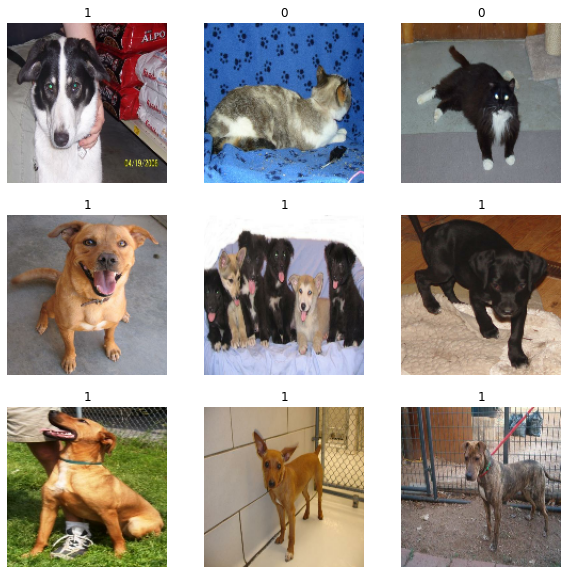

In [ ]:
# Choosing and showing 9 random images
# Label 1 is dog and label 0 is cat.
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Pre-fetching the data to optimize loading speed:

In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

### Data Augmentation
To create the effect of a larger dataset, one can modify the current dataset images to create more diversity and data samples. In the folowing sample, two data augmentation methods of random horizontal flipping and random rotation are introduced. More about data augmentation methods can be found [here](https://keras.io/api/layers/preprocessing_layers/image_preprocessing/).

Sequential method is an easy method to stack multiple layers of neural network on each other. You can read more about it [here](https://keras.io/guides/sequential_model/).

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1)
    ]
)

Here is a quick visualization of the data augmentation method defined on a random image:

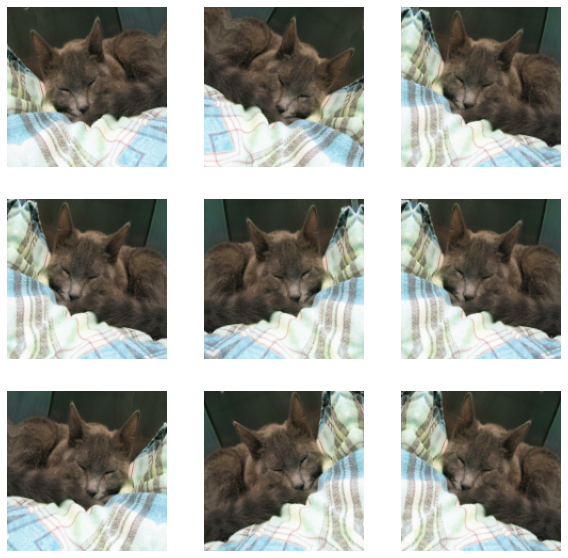

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

The input to a neural network should generally be small; therefore, we standardize the data by adding an extra layer to data augmentation: 
```
x = layers.experimental.preprocessing.Rescaling(1./255)(x)
```

**NOTE:** Data augmentation is only active during training time and will be bypassed during evaluation or prediction.

## Simple Convolutional Neural Network Model
In the following code, we define a simple convolutional neural network to see how the overall process works.

The code explanation is done by comments unde the code.

In [ ]:
# Reference: https://keras.io/guides/transfer_learning/

base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False, # Do not include the ImageNet classifier at the top.
) 

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.), the normalization layer
# does the following, outputs = (inputs - mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
normalization_3 (Normalizati (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_7 ( (None, 2048)              0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 2049

## Training the Model


In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/10
586/586 [==============================] - 51s 81ms/step - loss: 0.1995 - binary_accuracy: 0.9065 - val_loss: 0.0757 - val_binary_accuracy: 0.9701
Epoch 2/10
586/586 [==============================] - 46s 78ms/step - loss: 0.1169 - binary_accuracy: 0.9503 - val_loss: 0.0743 - val_binary_accuracy: 0.9720
Epoch 3/10
586/586 [==============================] - 46s 78ms/step - loss: 0.1101 - binary_accuracy: 0.9565 - val_loss: 0.0688 - val_binary_accuracy: 0.9748
Epoch 4/10
586/586 [==============================] - 46s 78ms/step - loss: 0.1081 - binary_accuracy: 0.9536 - val_loss: 0.0719 - val_binary_accuracy: 0.9735
Epoch 5/10
586/586 [==============================] - 46s 78ms/step - loss: 0.0981 - binary_accuracy: 0.9583 - val_loss: 0.0653 - val_binary_accuracy: 0.9752
Epoch 6/10
586/586 [==============================] - 46s 78ms/step - loss: 0.1032 - binary_accuracy: 0.9581 - val_loss: 0.0657 - val_binary_accuracy: 0.9750
Epoch 7/10
586/586 [==============================] 

# Multi-Class Image Classification (Graded)

## Script to download Alberta Wild Life Dataset
A copy of the dataset is also [available on Kaggle](https://www.kaggle.com/navidre/alberta-wildlife-dataset) for your reference. We will be using a local file here:

In [ ]:
# Downloading and unzipping tAhe urls.zip file containing the image urls
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1u2uZ71h6FKuhNwpsjDliRfz5EKBXmgfO' -O urls.zip
!unzip urls.zip

--2021-03-25 16:42:15--  https://docs.google.com/uc?export=download&id=1u2uZ71h6FKuhNwpsjDliRfz5EKBXmgfO
Resolving docs.google.com (docs.google.com)... 108.177.120.101, 108.177.120.138, 108.177.120.139, ...
Connecting to docs.google.com (docs.google.com)|108.177.120.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-8o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/pjoncf854s2312vohm6dg1a594v4hkts/1616690475000/07334224481093894294/*/1u2uZ71h6FKuhNwpsjDliRfz5EKBXmgfO?e=download [following]
--2021-03-25 16:42:16--  https://doc-10-8o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/pjoncf854s2312vohm6dg1a594v4hkts/1616690475000/07334224481093894294/*/1u2uZ71h6FKuhNwpsjDliRfz5EKBXmgfO?e=download
Resolving doc-10-8o-docs.googleusercontent.com (doc-10-8o-docs.googleusercontent.com)... 142.250.128.132, 2607:f8b0:4001:c32::84
Connecting to doc-10-8o-docs.googleusercontent.com (doc-10

In [ ]:
# Script to downlaod the images in a folder called images
# There will be separate folders for each keyword
import os
import urllib.request
from tqdm.notebook import tqdm
import json

keywords = ['snow_goose',
 'black_bear',
 'white_tail_deer',
 'wolf',
 'mountain_goat',
 'burrowing_owl',
 'great_horned_owl',
 'golden_eagle',
 'grizzly_bear',
 'mule_deer',
 'bald_eagle',
 'cougar',
 'canada_goose_bird',
 'river_otter',
 'bighorn_sheep',
 'moose',
 'bison',
 'caribou',
 'lynx',
 'pine_marten',
 'elk']

# Making sure the images folder exists
if not os.path.exists('images'):
    os.makedirs('images')

for keyword in keywords:
    # Loading the image links
    with open(f'./urls/{keyword}.json', 'r') as f:
        image_urls = json.load(f)

    # Checking if we have a folder with the name of the keyword
    if not os.path.exists(f'images/{keyword}'):
        os.makedirs(f'images/{keyword}')

    # Downloading images from the list
    for i in tqdm(range(len(image_urls)), desc=keyword):
      try:
          urllib.request.urlretrieve(image_urls[i], f'images/{keyword}/{i}.jpg')
      except ConnectionResetError:
          print(f'*** ConnectionResetError: {image_urls[i]}')
          pass
      except:
          print(f'Unexpected error: {sys.exc_info()[0]}')
          print(f'Error happended in url: {image_urls[i]}')
          pass  

In [ ]:
!ls images

bald_eagle     canada_goose_bird  great_horned_owl  mule_deer	     wolf
bighorn_sheep  caribou		  grizzly_bear	    pine_marten
bison	       cougar		  lynx		    river_otter
black_bear     elk		  moose		    snow_goose
burrowing_owl  golden_eagle	  mountain_goat     white_tail_deer


## Converting to Keras format and Splitting

We first need to import some needed libraries for the whole project:

In [ ]:
# TensorFlow
import tensorflow as tf
# Keras
from tensorflow import keras
# Easy layer-by-layer way to create neural networks in Keras
from tensorflow.keras import layers 
# Operating system package
import os
# A plotting library
import matplotlib.pyplot as plt
# NumPy
import numpy as np

Load the downloaded dataset and split them into 80% training and 20% validation sets and convert them to Keras dataset format using preprocessing methods. Please use '123' as the seed. Call them train_ds and val_ds.

In [ ]:
''' TODO: 80/20 split of the dataset from the folder.'''

We can see the class names using the following command:

In [ ]:
class_names = train_ds.class_names

In the following code box, please visualize several images with their labels:

In [ ]:
''' TODO: Visualization of images from the dataset.'''

In [ ]:
# Prefetching
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

## Data Augmentation
Define some data augmentations here and visualize some results.

In [ ]:
data_augmentation = keras.Sequential(
  [
    ''' TODO: Add relevant data augmentations. '''
  ]
)

In [ ]:
''' TODO: Visualize some results with data augmentations that you defined. '''

## Defining model, optimizer, loss, and metrics
In this section, choose a pretrained convolutional neural network from the Keras package. Create new model by freezing the weights of the pretrained model and adding a dense classification layer appropriate for the number of classes that you have. Explain the overall architecture of your model and why it is chosen that way. You can refer to the tutorial section for an example. Call the model variable 'model'.

In [ ]:
''' TODO: Define a model to be used. '''

In [ ]:
model.summary()

We also need to define optimizer, loss and accuracy.

In [ ]:
model.compile(optimizer='''TODO: Use a good optimizer, such as Adam.''',
              loss='''TODO: Use an appropriate loss function.''',
              metrics='''TODO: Define Metrics - Use accuracy at least.'''
             )

## Training and Validation

In this section, train the model for 10 epochs and validate it. You can refer to tutorial for a sample.

In [ ]:
''' TODO: Training and Validation for 10 epochs '''

### Analyzing the results

In this section, plot the training and validation losses **in the same plot** against the number of epochs.

In [ ]:
''' TODO: Plotting training and validation loss. '''

In the following box, explain what is happening in these graphs and if there is something wrong. 

TODO: Training and Validation loss graph explanation

In the following code box, first predict the class of all the validation images. Then create a confusion matrix using tf.math.confusion_matrix and then visualize it using the Seaborn package to find the most misclassified classes of images.

In [ ]:
val_preds = model.predict(val_ds)

'''TODO: Create confusion matrix and visualize it. '''

## Going back to model and data
Let's take a step back, look at the results and answer the questions mentioned in the handout and propose how you could improve the results.

**TODO: Explain in this box your plan of result improvement. **

In [ ]:
''' TODO: Do the updates here, train and validate the model again. Make sure that you are not continuing from the previous trained model.'''

In [ ]:
''' TODO: Plot the training and validation loss graphs against epochs again and explain the improvement. '''